In [1]:
import os
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
from scipy.interpolate import splrep,splev
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
import matplotlib.colors
#from sunpy.instr.aia import Response
import astropy.units as u
import ChiantiPy.tools.io as ch_io

import hissw
import synthesizAR
from synthesizAR.atomic import EmissionModel,ChIon
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

 using cli
 using CLI for selections


/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 reading chiantirc file


# Manually "Filling in" AIA Response Functions

In `synthesizAR`, our forward modeling code, we do **not** rely on the pre-calculated AIA temperature response functions, but instead calculate the response in each channel using the emissivity as calculated by CHIANTI along with the wavelength response function for each AIA channel. We do not include the contribution from the continuum.

We calculate the intensity in each pixel in each channel $i$ of the detector according to the equation,

$$
I_i = \int_{LOS}\mathrm{d}h\,n^2(h)K_i(T(h))
$$

where $n$ is the number density along the line of sight and $K_i$ is the temperature response function for channel $i$. Note that $I_i$ is in units of DN pixel$^{-1}$ s$^{-1}$. According to Boerner et al. (2012), the response function $K$ for channel $i$ is given by,

$$
K_i(T) = \int_0^{\infty}\mathrm{d}\lambda\,G(\lambda,T)R_i(\lambda)
$$

where $K$ has units DN cm$^{-5}$ s$^{-1}$ pixel$^{-1}$, $R_i$ is the wavelength response function of channel $i$ (multiplied by the plate scale) in units of cm$^2$ DN photon$^{-1}$ sr pixel$^{-1}$, and $G$ is the contribution function (for the spectral line emission only, i.e. not including continuum) and has units photons s$^{-1}$ cm$^{3}$ sr$^{-1}$.

The critical part of this expression is the contribution function $G$. Note that $G$ is summed over *all* ions (either in the chosen wavelength range or in the CHIANTI database). Thus, we can write,

$$
G(\lambda,T) = \sum_XG_X(\lambda,T) = \sum_X\left(\frac{0.83}{4\pi}\epsilon_X(\lambda,T)\mathrm{Ab}(X)\frac{N(X^{+m})}{N(X)}\frac{1}{n}\right)
$$

Note that in the SSW calculation of the temperature response functions, they do not include the factor of 0.83 so when we make our comparisons we will be sure to include this factor "by hand".

So, combining the expression for $G$ with that of $K_i$ gives use $K_i$ in terms of the instrument wavelength response and the relevant atomic information,

$$
K_i(T) = \int_0^{\infty}\mathrm{d}\lambda\,\sum_XG_X(\lambda,T)R_i(\lambda) = \frac{1}{n}\frac{0.83}{4\pi }\sum_X\int_0^{\infty}\mathrm{d}\lambda\,\epsilon_X(\lambda,T)\mathrm{Ab}(X)\frac{N(X^{+m})}{N(X)}R_i(\lambda) 
$$

And finally, combining all of this into our expression for intensity $I$, in units of DN s$^{-1}$ pixel$^{-1}$, gives,

$$
I_i = \int_{LOS}\mathrm{d}h\,n^2(h)K_i(T(h)) = \frac{0.83}{4\pi }\int_{LOS}\mathrm{d}h\,n(h)\sum_X\int_0^{\infty}\mathrm{d}\lambda\,\epsilon_X(\lambda,T(h))\mathrm{Ab}(X)\frac{N(X^{+m})}{N(X)}R_i(\lambda)
$$

Since we are solving the ionization fractions using an NEI approach, they will be a function of $T$ and $n$ as well, along the LOS, so we'll rewrite $N(X^{+m})/N(X)=\phi_X(n(h),T(h))$,

$$
I_i = \frac{0.83}{4\pi}\int_{LOS}\mathrm{d}h\,n(h) \sum_X\int_0^{\infty}\mathrm{d}\lambda\,\epsilon_X(\lambda,T(h))\mathrm{Ab}(X)\phi_X(n(h),T(h))R_i(\lambda)
$$

Our current problem is that our more sophisticated method for calculating the response in each channel seems to be missing critical portions of the response function in temperature space. Here, we'll use the emissivities (and various other quantities) from 

## Create Emission Model
Create a minimal, Fe-only (without Fe IX) emission model for testing purposes here. Reloading the emission model everytime is really annoying.

In [ ]:
fe_ions = [{'resolved_wavelengths':[]*u.angstrom,
            'name':'fe_{}'.format(i)} for i in range(2,27) if i !=9]

In [ ]:
emission_model = EmissionModel(fe_ions,
                               temperature=np.logspace(4.9,8,50)*u.K,
                               density=np.logspace(7.5,11,20)/(u.cm**3),
                               energy_unit='photon',
                               chianti_db_filename='/data/datadrive1/ar_forward_modeling/systematic_ar_study/chianti_db.h5')

In [ ]:
plt.figure(figsize=(8,8))
for ion in emission_model.ions[-15:]:
    plt.plot(emission_model.temperature_mesh[:,0],
             ion.fractional_ionization[:,0],
             label=ion.chianti_ion.meta['name']
            )
plt.legend(loc='best')
plt.xscale('log')
plt.ylim([0,1])

Calculate emissivity

In [ ]:
emission_model.calculate_emissivity()

Load the emission model that we used previously.

In [2]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

INFO:EmissionModel:Using CHIANTI HDF5 database in /data/datadrive1/ar_forward_modeling/systematic_ar_study/chianti_db.h5
INFO:EmissionModel:Creating ion h_1
INFO:EmissionModel:Creating ion he_2
INFO:EmissionModel:Creating ion c_6
INFO:EmissionModel:Creating ion n_7
INFO:EmissionModel:Creating ion o_8
INFO:EmissionModel:Creating ion ne_10
INFO:EmissionModel:Creating ion na_11
INFO:EmissionModel:Creating ion mg_12
INFO:EmissionModel:Creating ion al_13
INFO:EmissionModel:Creating ion si_14
INFO:EmissionModel:Creating ion p_15
INFO:EmissionModel:Creating ion s_16
INFO:EmissionModel:Creating ion cl_17
INFO:EmissionModel:Creating ion ar_18
INFO:EmissionModel:Creating ion k_19
INFO:EmissionModel:Creating ion ca_20
INFO:EmissionModel:Creating ion fe_26
INFO:EmissionModel:Creating ion ni_28
INFO:EmissionModel:Creating ion he_1
INFO:EmissionModel:Creating ion c_5
INFO:EmissionModel:Creating ion n_6
INFO:EmissionModel:Creating ion o_7
INFO:EmissionModel:Creating ion ne_9
INFO:EmissionModel:Creati

## Wavelength Response Function Comparison
First, load in the wavelength response functions from SunPy and those used in synthesizAR. We want to compare and make sure that these two match before getting into the rest of this.

Create the instruments.

In [3]:
aia_instrument = InstrumentSDOAIA([0,5e3]*u.s,use_temperature_response_functions=False,emission_model=emission_model)
aia_instrument_tresponse = InstrumentSDOAIA([0,5e3]*u.s,use_temperature_response_functions=True)

In [ ]:
response_sunpy = Response(channel_list=[94,131,171,193,211,335],ssw_path='/usr/local/ssw/')

Plot the SunPy response functions and those that are stored in synthesizAR from Steve's old data. We'll need to multiply the SunPy wavelength response functions by the plate scale because this is (presumably) already included in the synthesizAR wavelength responses. However, at this point, the functions I've stored in the synthesizAR package are the same as those calculated with SunPy here.

In [ ]:
response_sunpy.calculate_wavelength_response(include_crosstalk=True)

In [ ]:
fig,axes = plt.subplots(2,3,figsize=(15,8))
for i,ax in enumerate(axes.flatten()):
    center = int(aia_instrument.channels[i]['name'])
    wavelength = response_sunpy.wavelength_response[center]['wavelength']
    response = response_sunpy.wavelength_response[center]['response']
    ax.plot(wavelength,response*response_sunpy._channel_info[center]['plate_scale'],
            'o',markevery=3)
    interpolated_response = splev(wavelength,aia_instrument.channels[i]['wavelength_response_spline'],ext=1)
    interpolated_response = np.where(interpolated_response<0.,0,interpolated_response)
    ax.plot(wavelength,interpolated_response,'r')
    ax.set_title(r'{} $\AA$'.format(center))
    #ax.set_xlim([center-10,center+10])
    ax.set_xlim([25,400])
    ax.set_ylim([1e-16,1e-10])
    ax.set_yscale('log')
plt.tight_layout()

So these appear to be mostly similar, or at least there are no glaring differences that should be impacting our results that much. We'll use the SunPy wavelength response functions because they are a bit easier to work with.

## Calculate Temperature Response Functions from SSW

In [4]:
ssw_script = """
tresp = aia_get_response(/temp,/dn)
temperature = 10.^tresp.logte
response_94 = tresp.a94.tresp
response_131 = tresp.a131.tresp
response_171 = tresp.a171.tresp
response_193 = tresp.a193.tresp
response_211 = tresp.a211.tresp
response_335 = tresp.a335.tresp
"""

In [5]:
save_vars = ['temperature',
             'response_94', 
             'response_131',
             'response_171',
             'response_193',
             'response_211',
             'response_335']

In [6]:
ssw_runner = hissw.ScriptMaker(ssw_pkg_list=['sdo/aia'],ssw_path_list=['aia'])

In [7]:
ssw_response_functions = ssw_runner.run([(ssw_script,{})],
                                           save_vars=save_vars,cleanup=True,verbose=False)

## Build Temperature Response Functions
Now, use all of the ions in our emission model and convolve them with the wavelength response functions. We'll compare this with the SSW results. We'll take a 2D slice out of our 3D array

In [8]:
test_response_functions = {key['name']:np.zeros(emission_model.temperature_mesh.shape)*(u.cm**5)*u.count/u.s/u.pixel
                           for key in aia_instrument.channels}
#test_response_functions_sunpy = {key['name']:np.zeros(emission_model.temperature_mesh.shape)*(u.cm**5)*u.count/u.s/u.pixel
#                           for key in aia_instrument.channels}

In [9]:
for ion in emission_model.ions:
    print('Adding ion {}'.format(ion.chianti_ion.meta['name']))
    tmp_cube = (ion.emissivity * ion.fractional_ionization[:,:,np.newaxis]
                / emission_model.density_mesh[:,:,np.newaxis] * ion.chianti_ion.abundance / (4.*np.pi*u.steradian))
    for channel in aia_instrument.channels:
        # use synthesizar response functions
        interp_response = splev(ion.wavelength.value,channel['wavelength_response_spline'],ext=1)
        interp_response = (np.where(interp_response<0.,0.,interp_response)
                           * u.cm**2*u.count/u.photon*u.steradian/u.pixel
                          )
        test_response_functions[channel['name']] += np.dot(tmp_cube.value,interp_response.value)*tmp_cube.unit*interp_response.unit
        # use sunpy wavelength response functions
        #nots = splrep(response_sunpy.wavelength_response[int(channel['name'])]['wavelength'].value,
        #              response_sunpy.wavelength_response[int(channel['name'])]['response'].value)
        #interp_response = splev(ion.wavelength.value,nots,ext=1)
        #interp_response = (np.where(interp_response<0.,0.,interp_response)
        #                   * response_sunpy._channel_info[int(channel['name'])]['plate_scale']
        #                   * response_sunpy.wavelength_response[int(channel['name'])]['response'].unit
        #                  )
        #test_response_functions_sunpy[channel['name']] += np.dot(tmp_cube.value,interp_response.value)*tmp_cube.unit*interp_response.unit

Adding ion h_1
Adding ion he_2
Adding ion c_6
Adding ion n_7
Adding ion o_8
Adding ion ne_10
Adding ion na_11
Adding ion mg_12
Adding ion al_13
Adding ion si_14
Adding ion p_15
Adding ion s_16
Adding ion cl_17
Adding ion ar_18
Adding ion k_19
Adding ion ca_20
Adding ion fe_26
Adding ion ni_28
Adding ion he_1
Adding ion c_5
Adding ion n_6
Adding ion o_7
Adding ion ne_9
Adding ion na_10
Adding ion mg_11
Adding ion al_12
Adding ion si_13
Adding ion p_14
Adding ion s_15
Adding ion cl_16
Adding ion ar_17
Adding ion k_18
Adding ion ca_19
Adding ion fe_25
Adding ion ni_27
Adding ion zn_29
Adding ion c_4
Adding ion n_5
Adding ion o_6
Adding ion ne_8
Adding ion na_9
Adding ion mg_10
Adding ion al_11
Adding ion si_12
Adding ion p_13
Adding ion s_14
Adding ion ar_16
Adding ion k_17
Adding ion ca_18
Adding ion ti_20
Adding ion cr_22
Adding ion mn_23
Adding ion fe_24
Adding ion co_25
Adding ion ni_26
Adding ion zn_28
Adding ion c_3
Adding ion n_4
Adding ion o_5
Adding ion ne_7
Adding ion na_8
Addin

Make a "fake loop" object that just has temperature and density such that pressure is maintained at a constant. This gives us a 1D trace through the $(n,T)$ parameter space. Alternatively, we could stick a real loop in here to see exactly where we are sampling the response functions.

In [10]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    temperature = np.logspace(5,8,100)*u.K
    density = pressure_const/temperature
    
fake_loop = FakeLoop()

In [11]:
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

Plot the response function along the $n-T$ constant pressure curve space

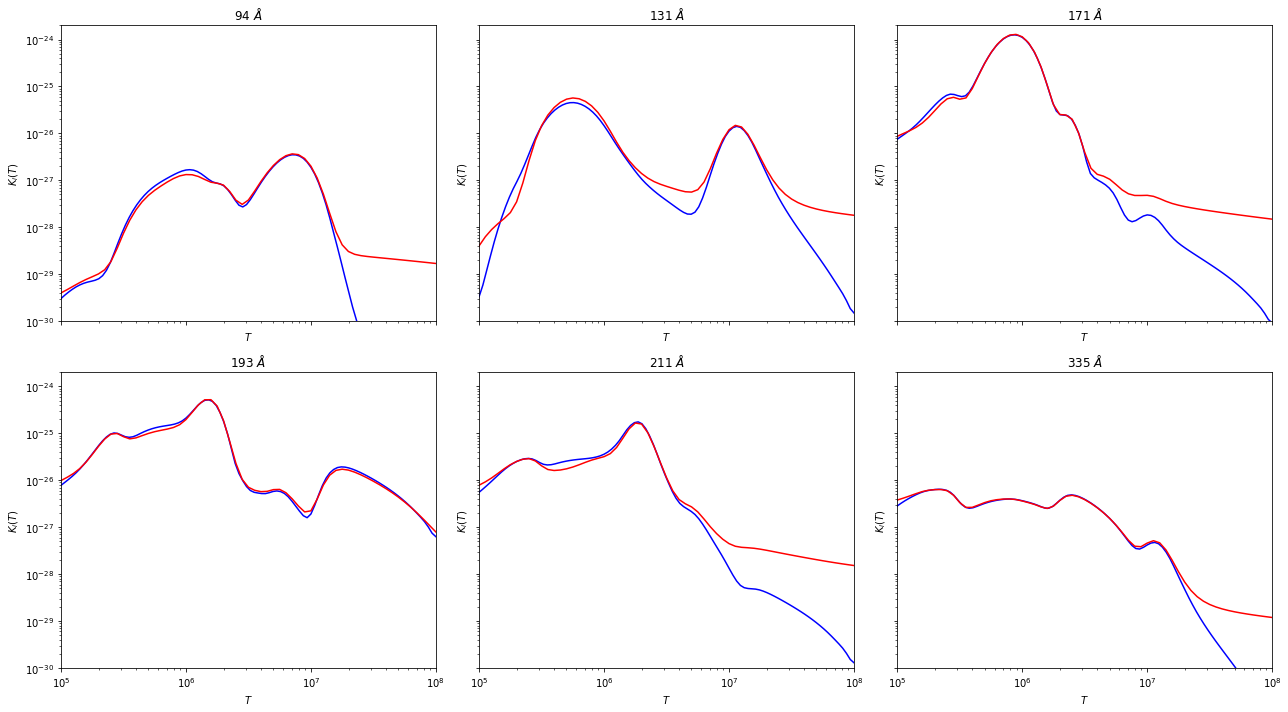

In [12]:
fig,axes = plt.subplots(2,3,figsize=(18,10),sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    center = aia_instrument.channels[i]['name']
    tn_cut = map_coordinates(test_response_functions[center].value,
                             np.vstack([i_temperature,i_density]))
    #tn_cut_sunpy = map_coordinates(test_response_functions_sunpy[center].value,
    #                         np.vstack([i_temperature,i_density]))
    #ax.plot(fake_loop.temperature,tn_cut_sunpy,'--b')
    ax.plot(fake_loop.temperature,tn_cut,'b')
    ax.plot(ssw_response_functions['temperature'],
            ssw_response_functions['response_{}'.format(center)],'r')
    ax.set_title(r'{} $\AA$'.format(center))
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(r'$K_i(T)$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-30,2e-24])
    ax.set_xlim([1e5,1e8])
plt.tight_layout()